# Выбор локации для скважины

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><ul ><a href="#Описание-задачи-и-данных" data-toc-modified-id="Описание-задачи-и-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Описание задачи и данных</a></span></li><li><span><a href="#Загрузка-и-подготовка-данных" data-toc-modified-id="Загрузка-и-подготовка-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Загрузка и подготовка данных</a></span></li><li><span><a href="#Обучение-и-проверка-модели" data-toc-modified-id="Обучение-и-проверка-модели-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение и проверка модели</a></span></li><li><span><a href="#Подготовка-к-расчёту-прибыли" data-toc-modified-id="Подготовка-к-расчёту-прибыли-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Подготовка к расчёту прибыли</a></span></li><li><span><a href="#Расчёт-прибыли-и-рисков" data-toc-modified-id="Расчёт-прибыли-и-рисков-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Расчёт прибыли и рисков</a></span></li><li><span><a href="#Чек-лист-готовности-проекта" data-toc-modified-id="Чек-лист-готовности-проекта-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Чек-лист готовности проекта</a></span></li></ul></div>

## Описание задачи и данных ##

Добывающей компании необходимо решить, где бурить новую скважину.

Предоставлены пробы нефти в трёх регионах: в каждом 100 000 месторождений, где измерили качество нефти и объём её запасов. Необходимо построить модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль, а также проанализировать возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

Описание данных

Данные геологоразведки трех регионов находятся в трех разных файлах.

- id — уникальный идентификатор скважины;
- f0, f1, f2 — три признака точек (неважно, что они означают, но сами признаки значимы);
- product — объём запасов в скважине (тыс. баррелей).

Условия задачи:
- Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).
- При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
- Бюджет на разработку скважин в регионе — 10 млрд рублей.
- При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
- После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.
- Данные синтетические: детали контрактов и характеристики месторождений не разглашаются.

## Загрузка и подготовка данных

Импортируем необходимые библиотеки и инструменты.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy import stats as st
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

Сохраним данные по каждому региону в отдельные переменные.

In [2]:
geo_data_0 = pd.read_csv('geo_data_0.csv') # данные по региону О
geo_data_1 = pd.read_csv('geo_data_1.csv') # данные по региону 1
geo_data_2 = pd.read_csv('geo_data_2.csv') # данные по региону 2

Напишем функцию, которая по каждому региону выведет на экран первые 5 строк таблицы, основную информацию о таблице, количество полных дубликатов, а также гистограммы по каждому столбцу.

In [3]:
def data_info(data):
    print('Первые пять строк таблицы:')
    print(data.head())
    print()
    print('Основная информация о таблице:')
    data.info()
    print()
    print('Количество полных дубликатов:', data.duplicated().sum())
    print()
    data.hist(figsize=(15, 8))

**Регион 0**

Первые пять строк таблицы:
      id        f0        f1        f2     product
0  txEyH  0.705745 -0.497823  1.221170  105.280062
1  2acmU  1.334711 -0.340164  4.365080   73.037750
2  409Wp  1.022732  0.151990  1.419926   85.265647
3  iJLyR -0.032172  0.139033  2.978566  168.620776
4  Xdl7t  1.988431  0.155413  4.751769  154.036647

Основная информация о таблице:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB

Количество полных дубликатов: 0



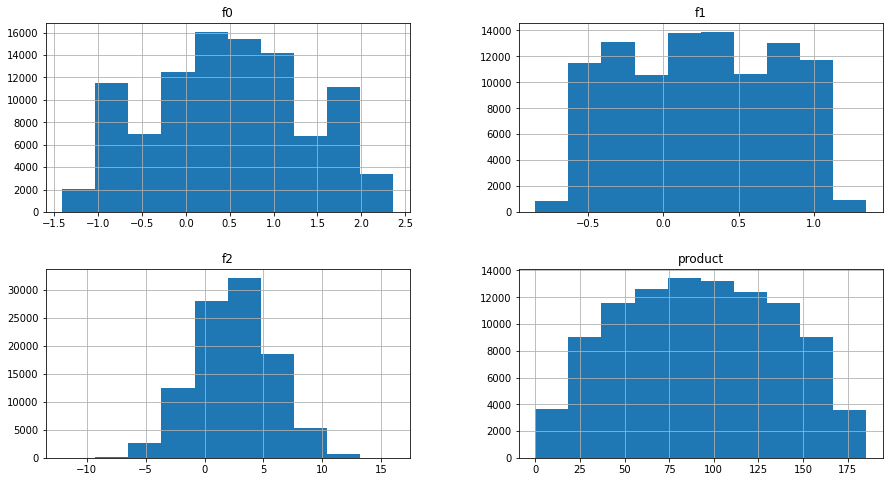

In [4]:
data_info(geo_data_0)

В данных отсутствуют пропуски и дубликаты. В целом, наблюдается близкое к нормальному распределение значений в признаках и целевом признаке.

**Регион 1**

Первые пять строк таблицы:
      id         f0         f1        f2     product
0  kBEdx -15.001348  -8.276000 -0.005876    3.179103
1  62mP7  14.272088  -3.475083  0.999183   26.953261
2  vyE1P   6.263187  -5.948386  5.001160  134.766305
3  KcrkZ -13.081196 -11.506057  4.999415  137.945408
4  AHL4O  12.702195  -8.147433  5.004363  134.766305

Основная информация о таблице:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB

Количество полных дубликатов: 0



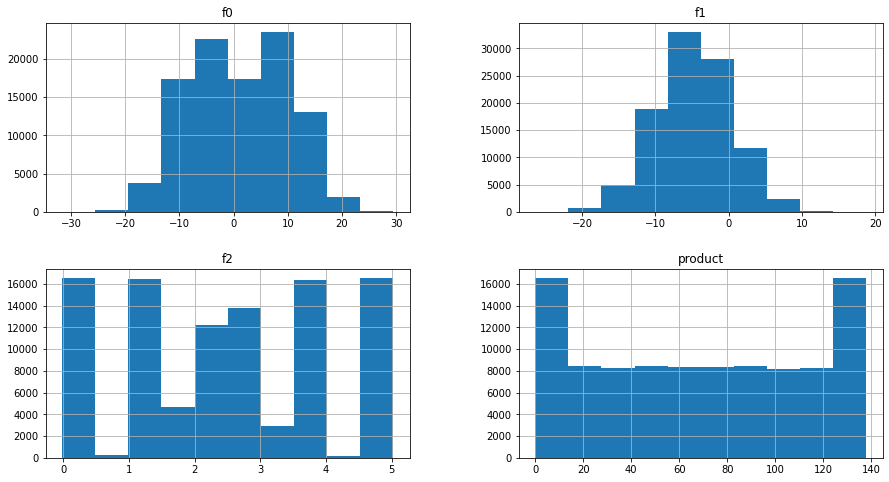

In [5]:
data_info(geo_data_1)

В данных отсутствуют пропуски и дубликаты. По признакам f0 и f1 наблюдается близкое к нормальному распределение значений. По признаку f2 и целевому признаку распределение значений отличается от нормального.

**Регион 2**

Первые пять строк таблицы:
      id        f0        f1        f2     product
0  fwXo0 -1.146987  0.963328 -0.828965   27.758673
1  WJtFt  0.262778  0.269839 -2.530187   56.069697
2  ovLUW  0.194587  0.289035 -5.586433   62.871910
3  q6cA6  2.236060 -0.553760  0.930038  114.572842
4  WPMUX -0.515993  1.716266  5.899011  149.600746

Основная информация о таблице:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB

Количество полных дубликатов: 0



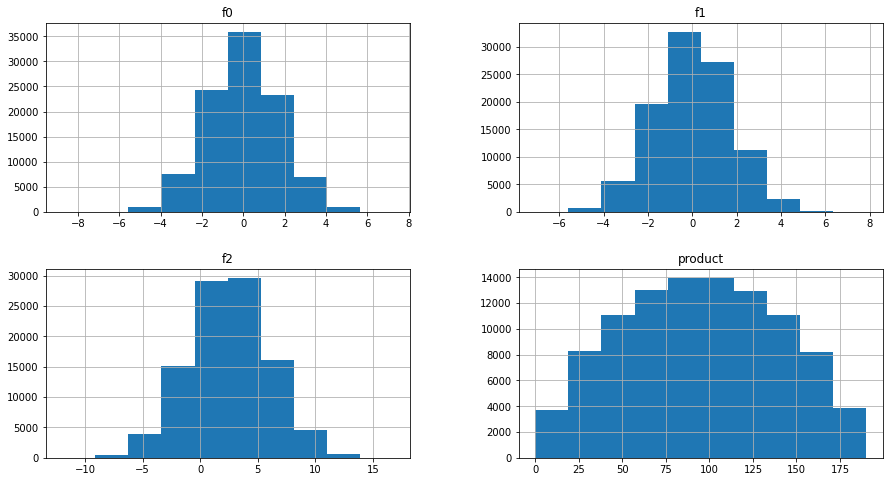

In [6]:
data_info(geo_data_2)

В данных отсутствуют пропуски и дубликаты. Значения в признаках и целевом признаке распределены нормально.

## Обучение и проверка модели

Теперь для каждого региона обучим модель линейной регрессии и рассчитаем основные метрики на полученных данных.

Построим две функции lin_reg и scores.

Функция lin_reg:
- делит данные на признаки и целевой признак
- делит признаки и целевой признак на обучающую и валидационную выборки
- масштабирует признаки
- обучает модель и делает предсказание на валидационных данных

Функция scores:
- рассчитывает средний запас предсказанного сырья и значение метрики RMSE
- рассчитывает медианный запас предсказанного сырья и значение метрики MAE
- рассчитывает коэффициент детерминации
- строит график распределения признаков, фактического продукта и предсказанных значений

In [7]:
def lin_reg(data):
    
    # разделение данных на признаки и целевой признак, на обучающую и валидационную выборки
    features = data.drop(['id', 'product'], axis=1)
    target = data['product']
    features_train, features_valid, target_train, target_valid = train_test_split(
        features, target, test_size=0.25, random_state=12345)
    
    # масштабирование признаков
    scaler = StandardScaler()
    scaler.fit(features_train)
    features_train = scaler.transform(features_train)
    features_valid = scaler.transform(features_valid)
    pd.options.mode.chained_assignment = None
    
    # обучение модели
    model = LinearRegression()
    model.fit(features_train, target_train)
    predicted_valid = pd.Series(model.predict(features_valid))
    
    return target_valid, predicted_valid

In [8]:
def scores(target, predicted, data):
    print('Средний запас предсказанного сырья:', predicted.mean())
    print('Корень из средней квадратичной ошибки, RMSE:', mean_squared_error(target, predicted) ** 0.5)
    print()
    print('Медианный запас предсказанного сырья:', predicted.median())
    print('Среднее абсолютное отклонение, MAE:', mean_absolute_error(target, predicted))
    print()
    print('Коэффициент детерминации:', r2_score(target, predicted))
    print()
    print('Распределение значений:')
    f, axs = plt.subplots(ncols=3, figsize=(15, 4))
    data['f0'].plot(kind='hist', histtype='step', color='red', bins=100, label='f0', grid=True, subplots=True, ax=axs[0], legend=True, linewidth=2, alpha=0.5)
    data['f1'].plot(kind='hist', histtype='step', color='green', bins=100, label='f1', grid=True, subplots=True, ax=axs[0], legend=True, linewidth=2, alpha=0.5)
    data['f2'].plot(kind='hist', histtype='step', color='yellow', bins=100, label='f2', grid=True, subplots=True, ax=axs[1], legend=True, linewidth=2, alpha=0.5)
    predicted.plot(kind='hist', histtype='step', color='blue', bins=100, label='predicted', grid=True, subplots=True, ax=axs[2], legend=True, linewidth=2, alpha=0.7)
    target.plot(kind='hist', histtype='step', color='purple', bins=100, label='product', grid=True, subplots=True, ax=axs[2], legend=True, linewidth=2, alpha=0.5)

**Регион 0**

In [9]:
target_valid_0, predicted_valid_0 = lin_reg(geo_data_0)

Средний запас предсказанного сырья: 92.59256778438035
Корень из средней квадратичной ошибки, RMSE: 37.5794217150813

Медианный запас предсказанного сырья: 92.66188351790804
Среднее абсолютное отклонение, MAE: 30.919600777151313

Коэффициент детерминации: 0.27994321524487786

Распределение значений:


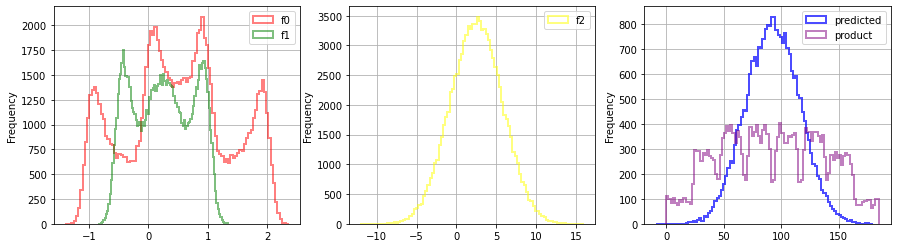

In [10]:
scores(target_valid_0, predicted_valid_0, geo_data_0)

Средний и медианный предсказанный запас по региону 0 практически равны, следовательно, значения предсказаний распределены нормально.

При этом график предсказаний максимально приближен к графику распределения признака f2.

Низкое значение коэффициента детерминации говорит о низком качестве модели, что также подтверждают значения метрик RMSE и MAE (отклонения в обоих случаях составляют около трети от среднего и медианного предсказаний).

**Регион 1**

In [11]:
target_valid_1, predicted_valid_1 = lin_reg(geo_data_1)

Средний запас предсказанного сырья: 68.728546895446
Корень из средней квадратичной ошибки, RMSE: 0.893099286775617

Медианный запас предсказанного сырья: 57.85158588242699
Среднее абсолютное отклонение, MAE: 0.7187662442124758

Коэффициент детерминации: 0.9996233978805127

Распределение значений:


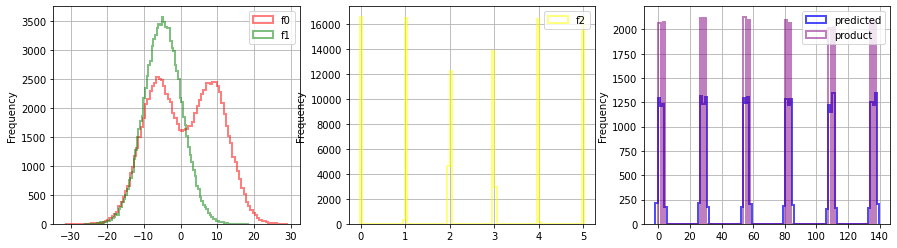

In [12]:
scores(target_valid_1, predicted_valid_1, geo_data_1)

По региону 1 коэффициент детерминации практически равен единице, что говорит о высоком качестве модели и почти идеальных предсказаниях.

При этом наблюдается необычное распределение значений предсказаний, похожее на распределение значений признака f2 и продукта.

Несмотря на более низкие значения среднего и медианного запаса предсказанного сырья по сравнению с другими регионами, метрики RMSE и MAE также крайне низкие, что подтверждает высокую точность предсказаний.

**Регион 2**

In [13]:
target_valid_2, predicted_valid_2 = lin_reg(geo_data_2)

Средний запас предсказанного сырья: 94.96504596800489
Корень из средней квадратичной ошибки, RMSE: 40.02970873393434

Медианный запас предсказанного сырья: 95.03120442123549
Среднее абсолютное отклонение, MAE: 32.792652105481814

Коэффициент детерминации: 0.20524758386040443

Распределение значений:


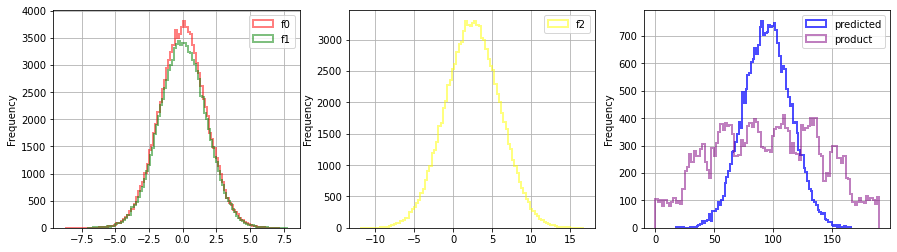

In [14]:
scores(target_valid_2, predicted_valid_2, geo_data_2)

Средний и медианный предсказанный запас по региону 2 практически равны, следовательно, значения предсказаний распределены нормально.

График распределения предсказаний поход на графики распределения всех признаков, но отличается от распределения продукта.

Низкое значение коэффициента детерминации говорит о низком качестве модели, что также подтверждают значения метрик RMSE и MAE (отклонения в обоих случаях составляют более трети от среднего и медианного предсказаний).

Таким образом, по результатам изучения данных по трем регионам, самые точные предсказания получены по региону 1. Предположительно, в данных по региону 1 присутствует линейная зависимость целевого признака от значений признаков.

Также можно заметить более сильное влияние признака f2 (по сравнению с двумя другими признаками) на результат предсказаний по всем трем регионам.

## Подготовка к расчёту прибыли

Сохраним необходимые для расчета прибыли значения в отдельных переменных.

In [15]:
FIELD_NUM_FOR_SEARCH = 500 # количество месторождений для исследования

In [16]:
FIELD_NUM_FOR_DEVELOP = 200 # количество месторождений для разработки

In [17]:
BUDGET = 10000000000 # бюджет на разработку месторождений

In [18]:
ONE_BARREL_INCOME = 450 # доход с одного барреля сырья

In [19]:
ONE_UNIT_PRODUCT_INCOME = ONE_BARREL_INCOME * 1000 # доход с одной единицы продукта (составляет 1000 баррелей)

In [20]:
LOSS_THRESHOLD = 0.025 # максимальная вероятность убытков

In [21]:
CONFIDENCE_INTERVAL = 0.95 # % доверительного интервала

In [22]:
LOWER = (1 - CONFIDENCE_INTERVAL) / 2 # нижний порог доверительного интервала

In [23]:
UPPER = CONFIDENCE_INTERVAL + LOWER # верхний порог доверительного интервала

Рассчитаем количество единиц продукта, которое необходимо получить с каждого месторождения для покрытия расходов на их разработку.

In [24]:
BUDGET / FIELD_NUM_FOR_DEVELOP / ONE_UNIT_PRODUCT_INCOME

111.11111111111111

С каждого месторождения необходимо получить более 111 единиц продукта для покрытия расходов.

В регионах 0 и 2 средний и медианный предсказанный запас сырья составляет чуть больше 90 единиц продукта. При этом средние отклонения (и абсолютное, и корень из квадратичного) составляют от 30 до 40 единиц продукта.

В регионе 1 средний запас предсказанного сырья составляет почти 69 единиц продукта, медианный - почти 58. При этом средние отклонения практически нулевые.

На первый взгляд, в регионах 0 и 2 больше вероятность выйти на положительную прибыль, выбрав случайным образом 500 месторождений и разработать 200 лучших из них на основе предсказаний модели. 

Однако у моделей по регионам 0 и 2 значительно более низкое качество, чем у модели по региону 1. Соответственно, предсказанные значения по регионам 0 и 2 существенно отличаются от фактических данных.

## Расчёт прибыли и рисков 

Напишем функцию для расчета прибыли, которая на основе предсказаний отбирает лучшие 200 месторождений и рассчитывает доход от них на основании фактически добытого сырья.

In [25]:
def profit(target, predicted):
    predicted_sort = predicted.sort_values(ascending=False)
    target_prep = pd.Series(target).reset_index(drop=True)
    selected = target_prep[predicted_sort.index][:FIELD_NUM_FOR_DEVELOP]
    profit = ONE_UNIT_PRODUCT_INCOME * selected.sum() - BUDGET
    return profit

Также напишем функцию, которая для каждого региона 1000 раз случайным образом отбирает 500 месторождений и рассчитывает прибыль по 200 лучшим из них. По результатам применения функции на экран выводятся:
- средняя прибыль по результату 1000 итераций
- 95% доверительный интервал
- вероятность получения отрицательной прибыли

Применим данную функцию к данным по трем регионам.

In [26]:
def risk_prob(target, predicted):
    state = np.random.RandomState(12345)
    
    # расчет прибыли для 1000 случайных выборок месторождений
    values = []
    for i in range(1000):
        predicted_sample = predicted.sample(n=500, random_state=state, replace=True)
        values.append(profit(target, predicted_sample))
    values = pd.Series(values)
    
    # средняя прибыль по 1000 случайных выборок
    mean_profit = values.mean()
    print('Средняя прибыль:', mean_profit)
    
    # расчет доверительного интервала
    lower = values.quantile(LOWER)
    upper = values.quantile(UPPER)
    confidence_interval = [lower, upper]
    print('95% доверительный интервал:', confidence_interval)

    # расчет риска убытков
    risk_values_counter = 0
    values_counter = 0
    for i in values:
        if i < 0:
            risk_values_counter += 1
        values_counter += 1
    loss_risk = risk_values_counter / values_counter
    print(f'Риск убытков: {loss_risk * 100}%')
    
    if loss_risk > LOSS_THRESHOLD:
        print('Риск убытков выше целевого значения. Регион не подходит для разработки.')
    else:
        print('Риск убытков не превышает целевое значение. Регион подходит для разработки.')

**Регион 0**

In [27]:
risk_prob(target_valid_0, predicted_valid_0)

Средняя прибыль: 396164984.8023711
95% доверительный интервал: [-111215545.89049524, 909766941.5534226]
Риск убытков: 6.9%
Риск убытков выше целевого значения. Регион не подходит для разработки.


**Регион 1**

In [28]:
risk_prob(target_valid_1, predicted_valid_1)

Средняя прибыль: 456045105.7866608
95% доверительный интервал: [33820509.39898369, 852289453.866036]
Риск убытков: 1.5%
Риск убытков не превышает целевое значение. Регион подходит для разработки.


**Регион 2**

In [29]:
risk_prob(target_valid_2, predicted_valid_2)

Средняя прибыль: 404403866.5683568
95% доверительный интервал: [-163350413.39560103, 950359574.9237995]
Риск убытков: 7.6%
Риск убытков выше целевого значения. Регион не подходит для разработки.


Только в регионе 1 риск убытков составляет менее 2,5% при случайном выборе 500 месторождений для исследования. В двух других регионах риск убытков более 2,5%.

Также только по региону 1 с помощью модели машинного обучения удалось получить самые точные предсказания, практически соответствующие реальным данным.

Рекомендовано выбрать регион 1 для разработки месторождений.